# Basic Preprocessing and Connected Components

In [1]:
from tifffile import imread, imsave
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_image(img_3d, slice_z):
    if slice_z:
        img_slice = img_3d[slice_z, :, :]
    else:
        img_slice = img_3d
            
    plt.imshow(img_slice, cmap=plt.cm.gray)
    plt.figure(figsize=(40,40))
    plt.show()

## Image Histogram

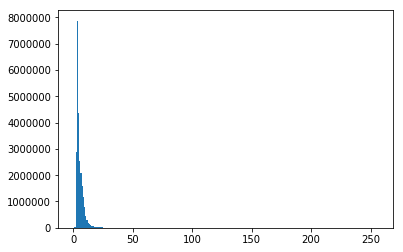

In [2]:
img = imread('cell_detection_2.tiff')[:,:,:,0]
plt.hist(img.ravel(),256,[0,256])
plt.show()

shape_z, shape_y, shape_x = img.shape

## Otsu's Binarization

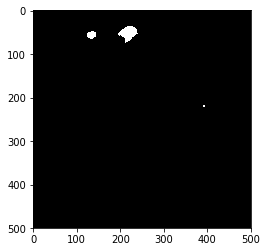

In [3]:
import time
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img)
binary_img = (img > thresh) * 255
binary_img = binary_img.astype(np.uint8)

show_image(binary_img, 25)

start = time.clock()

## Adaptive Thresholding

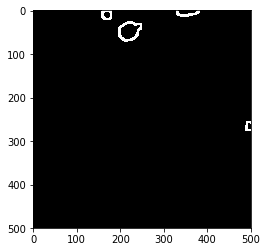

In [4]:
img_threshold = np.zeros((shape_z, shape_y, shape_x))

for z_slice in range(shape_z):
    img_threshold[z_slice, :, :] = cv2.adaptiveThreshold(binary_img[z_slice, :, :], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

img_threshold = abs(img_threshold - 255)

show_image(img_threshold, 30)

## Morphological Hole Filling (Dilation)

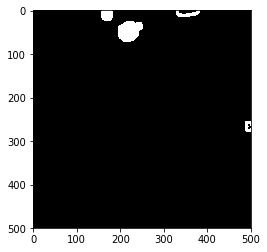

In [5]:
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import binary_dilation

dilated_img = np.zeros((shape_z, shape_y, shape_x))

for z_slice in range(shape_z):
    dilated_img[z_slice, :, :] = binary_fill_holes(binary_dilation(img_threshold[z_slice, :, :]))

dilated_img *= 255

show_image(dilated_img, 30)

## Connected Components

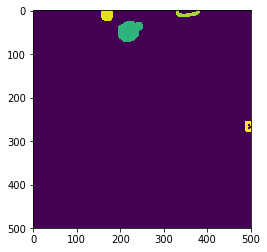

calculating centroid 10
calculating centroid 20
calculating centroid 30
calculating centroid 40
calculating centroid 50
calculating centroid 60
calculating centroid 70
calculating centroid 80
Predictions saved to CSV
10.337015000000001


In [6]:
from skimage import measure
import math
import csv

def find_centroid(voxels):
    sum_z = 0.0
    sum_y = 0.0
    sum_x = 0.0
    
    l = float(len(voxels))

    if l == 0:
        return None
    
    for voxel in voxels:
        z, y, x = voxel
        sum_z += z
        sum_y += y
        sum_x += x
    
    return (math.ceil(sum_z/l), math.ceil(sum_y/l), math.ceil(sum_x/l))

cc_img = measure.label(dilated_img, background=0)

plt.imshow(cc_img[30, :, :])
plt.show()

img_segments = np.unique(cc_img, return_counts=True)

centroids = []

for segment_index in range(1, len(img_segments[0])):
    if segment_index % 10 == 0: print('calculating centroid {}'.format(segment_index))
    voxels = [i for i in zip(*np.where(cc_img == segment_index))]
    centroids.append(find_centroid(voxels))

with open('cell_detection_2_predicted.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(centroids)

print('Predictions saved to CSV')
end = time.clock()
print(end - start)